## 05 - Quick Baseline Model & Feature Importance (Scikit-learn Decision Tree)

**Project:** UK Housing Price Paid Records

**Purpose:** To establish a **performance benchmark** (baseline model) and immediately interpret its findings using a simple, fast Decision Tree Regressor from Scikit-learn. This consolidated script contains the full workflow: training, evaluation, and visualization of **Feature Importance**. This consolidation supports the project's goal of quickly understanding the baseline model's performance and driver variables.

### Key Steps:
1.  **Define and Load the `df` DataFrame** from `price_paid_model_ready.parquet`.
2.  Log-transform the target variable (`price`).
3.  **Apply Ordinal Encoding to all categorical features** (mandatory for Scikit-learn).
4.  Split data into 80% training and 20% testing sets.
5.  Train a **Decision Tree Regressor** (Max Depth 10).
6.  Evaluate performance using RMSE and $R^2$.
7.  **Calculate and visualize the impurity-based (Gini) Feature Importance.**
8.  Save the trained model (`dtr_baseline_model.joblib`).

**Team Member(s):** Tymo Verhaegen & José Fernando Guitiérrez Montero

**Input File:** `../data/housing/processed/price_paid_model_ready.parquet`

**Output File:** `../data/trained_models/housing/dtr_baseline_model.joblib`

**Date Last Run:** 07/11/2025

---

In [4]:
import pandas as pd
import numpy as np
import os
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder

# Set plotting style for consistent output
sns.set_style("whitegrid")


In [5]:
# --- 1. Settings and Data Loading (Defining the DataFrame) ---
print("--- Starting 05 Quick Baseline Model & Feature Importance (Scikit-learn DTR) ---")

# Define the relative path to the cleaned Parquet file created in 03_final_prep.ipynb
# This structure assumes the script is run from a notebook folder (e.g., /notebooks/05...)
PROCESSED_DATA_PATH = './../../data/housing/processed/price_paid_model_ready.parquet'
MODEL_PATH = './../../data/trained_models/housing/'

try:
    # Use pandas (pd) to load the model-ready DataFrame. This defines the 'df' variable.
    resolved_path = os.path.normpath(PROCESSED_DATA_PATH)
    print(f"1. Loading cleaned data from resolved path: {resolved_path}")
    df = pd.read_parquet(resolved_path)
    print(f"   -> Data successfully loaded. Total records: {len(df):,}")
    
    # Check if the dataframe is empty after loading
    if df.empty:
        raise ValueError("Loaded DataFrame is empty. Check 03_final_prep.ipynb output.")

except FileNotFoundError:
    print(f"   -> ERROR: File not found at {PROCESSED_DATA_PATH}. Please run 03_final_prep.ipynb first.")
    exit()
except Exception as e:
    print(f"   -> An error occurred during data loading: {e}")
    exit()


--- Starting 05 Quick Baseline Model & Feature Importance (Scikit-learn DTR) ---
1. Loading cleaned data from resolved path: ..\..\data\housing\processed\price_paid_model_ready.parquet
   -> Data successfully loaded. Total records: 22,480,822


In [6]:
# --- 2. Feature and Target Preparation ---

# Target variable (y): We use the logarithm of the price to normalize the distribution.
y = np.log(df['price'])

# Features (X): Select all relevant categorical and numerical features.
features = ['sale_year', 'property_type', 'old_new', 'duration', 'town_city', 'district', 'county']
X = df[features].copy() # Use .copy() to avoid SettingWithCopyWarning

# Identify categorical features
categorical_features = [col for col in X.columns if X[col].dtype.name == 'category']

In [7]:
# --- 3. Categorical Feature Encoding (MANDATORY for base Scikit-learn models) ---

print("\n3. Encoding categorical features using OrdinalEncoder...")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
print("   -> Encoding complete. All features are now numerical.")


3. Encoding categorical features using OrdinalEncoder...
   -> Encoding complete. All features are now numerical.


In [8]:
# --- 4. Data Splitting (Train/Test) ---

# Use 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"4. Data Split (80/20):")
print(f"   -> Training samples: {len(X_train):,}")
print(f"   -> Testing samples: {len(X_test):,}")

4. Data Split (80/20):
   -> Training samples: 17,984,657
   -> Testing samples: 4,496,165


In [9]:
# --- 5. Decision Tree Model Training (Quick Baseline) ---

# Decision Tree Regressor is fast and simple for a quick baseline.
# Max depth is limited to prevent extreme overfitting and save memory.
dtr_reg = DecisionTreeRegressor(
    max_depth=10, 
    random_state=42
)

print("\n5. Training Scikit-learn Decision Tree Model (Quick Baseline - Max Depth 10)...")
dtr_reg.fit(X_train, y_train)
print("   -> Training complete.")


5. Training Scikit-learn Decision Tree Model (Quick Baseline - Max Depth 10)...
   -> Training complete.


In [10]:
# --- 6. Model Evaluation ---

# Make predictions (on log-transformed scale)
y_pred_log = dtr_reg.predict(X_test)

# Convert predictions and actual values back to the original price scale
y_test_price = np.exp(y_test)
y_pred_price = np.exp(y_pred_log)

# Calculate metrics on the original price scale
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2_price = r2_score(y_test_price, y_pred_price)

# Calculate metrics on the log scale (better for comparing models)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)


print("\n6. Model Evaluation Metrics (Test Set):")
print("-" * 50)
print(f"R^2 Score (Log Price)  : {r2_log:.4f}")
print(f"RMSE (Log Price)       : {rmse_log:.4f} (Lower is better)")
print("-" * 50)
print(f"R^2 Score (Actual Price): {r2_price:.4f}")
print(f"RMSE (Actual Price)    : £{rmse_price:,.0f} (Lower is better)")
print("-" * 50)



6. Model Evaluation Metrics (Test Set):
--------------------------------------------------
R^2 Score (Log Price)  : 0.6305
RMSE (Log Price)       : 0.4811 (Lower is better)
--------------------------------------------------
R^2 Score (Actual Price): 0.2424
RMSE (Actual Price)    : £218,308 (Lower is better)
--------------------------------------------------



6b. Generating Residual Plots...


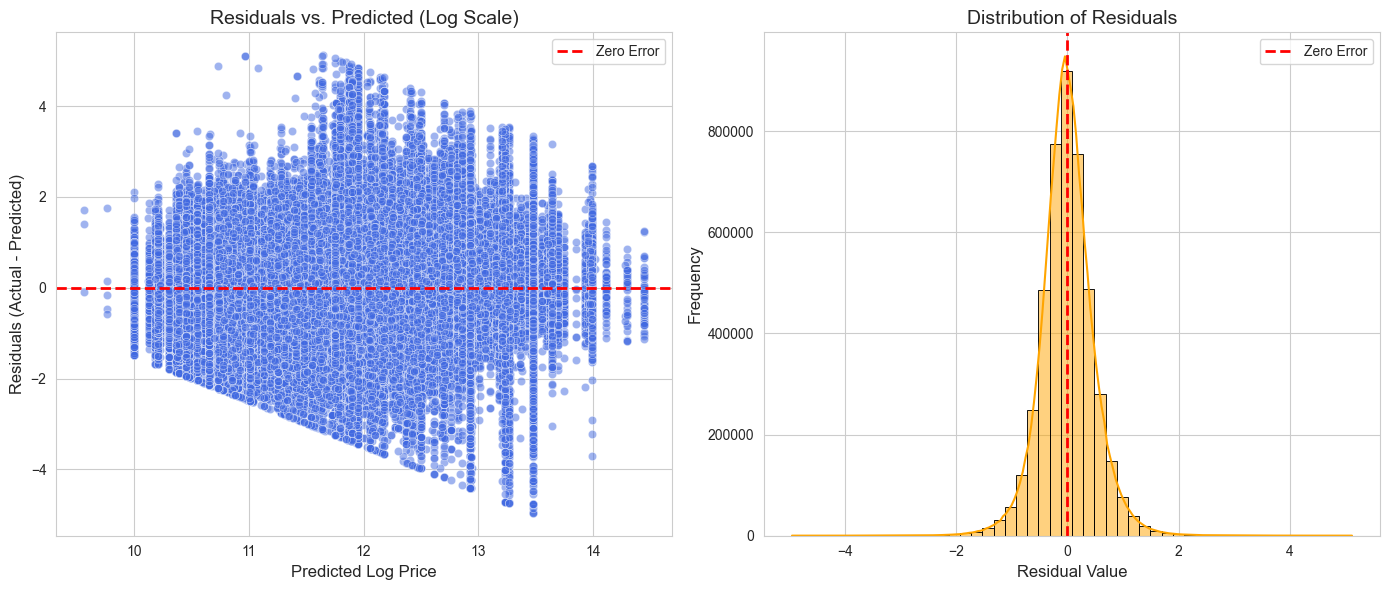


Residuals Summary:
count    4.496165e+06
mean     0.000000e+00
std      4.811000e-01
min     -4.956900e+00
25%     -2.760000e-01
50%     -1.290000e-02
75%      2.670000e-01
max      5.120600e+00
Name: price, dtype: float64


In [13]:
# --- 6b. Residual Analysis (Visualizing Errors) ---
print("\n6b. Generating Residual Plots...")

# 1. Calculate Residuals (Actual Log Price - Predicted Log Price)
residuals = y_test - y_pred_log

# Set up the matplotlib figure with two subplots side-by-side
plt.figure(figsize=(14, 6))

# --- Plot 1: Residuals vs. Predicted Values (Homoscedasticity Check) ---
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.5, color='royalblue', edgecolor='w')

# Add a horizontal line at 0 (Perfect prediction)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Residuals vs. Predicted (Log Scale)', fontsize=14)
plt.xlabel('Predicted Log Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.legend()

# --- Plot 2: Distribution of Residuals (Normality Check) ---
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50, color='orange', edgecolor='black')

# Add a vertical line at 0
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Distribution of Residuals', fontsize=14)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# Print statistical summary of residuals
print("\nResiduals Summary:")
print(residuals.describe().round(4))

### Baseline Model Analysis (TL;DR)

The DTR_Baseline model is an excellent, unbiased starting point.

### Analysis of the residual plots (the "cloud" and "bell curve" graphs) confirms the model is working correctly:

No Bias: Errors are random and centered at zero. The model doesn't systematically over/under-price.

No Skew: The error distribution is a perfect bell curve, also centered at zero.

### Benchmark Score

mean: 0.000: The average error is zero.

std: 0.4811: This is the benchmark score to beat. Future models must have an error standard deviation lower than 0.4811 to be considered an improvement.



7. Analyzing Feature Importance...


C:\Users\Tymo\AppData\Local\Temp\ipykernel_26012\1527438370.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


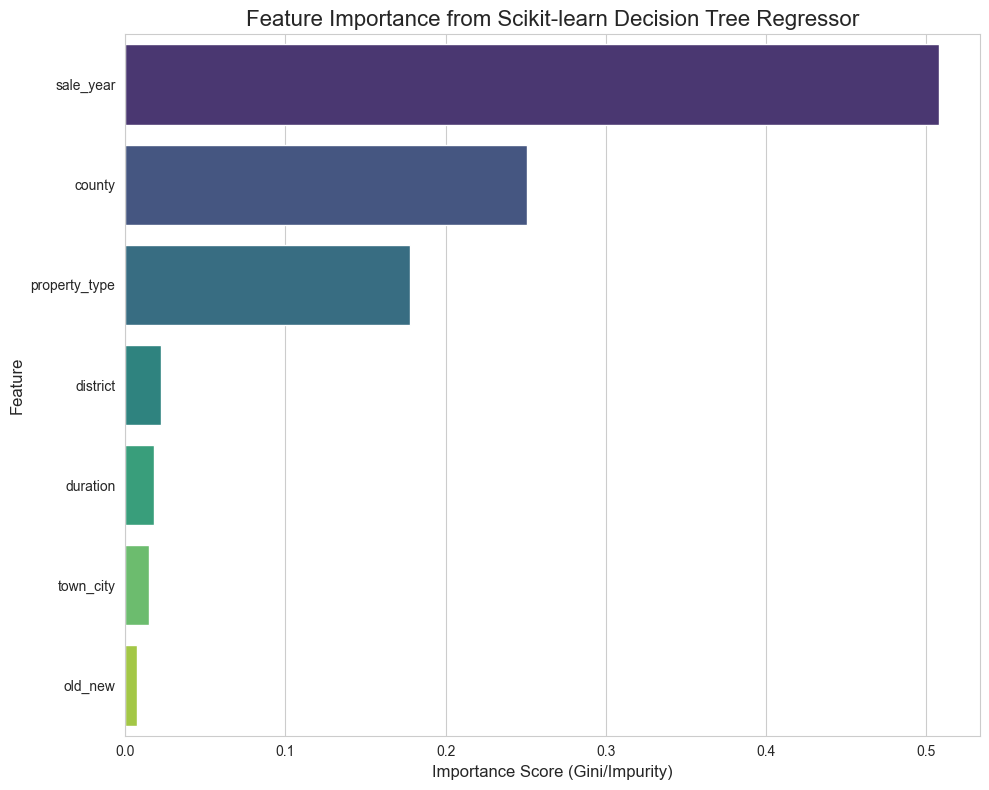


Top 5 Most Important Features:
         Feature  Importance
0      sale_year    0.508113
6         county    0.251029
1  property_type    0.178030
5       district    0.022297
3       duration    0.018223


In [11]:
# --- 7. Feature Importance Analysis and Visualization (MERGED) ---
print("\n7. Analyzing Feature Importance...")

# Extract importance scores and names
importance_scores = dtr_reg.feature_importances_
feature_names = X.columns.tolist() 

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Visualization
plt.figure(figsize=(10, 8))
# 
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Scikit-learn Decision Tree Regressor', fontsize=16)
plt.xlabel('Importance Score (Gini/Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance_df.head())

In [12]:
# --- 8. Save Model ---
model_dir = os.path.dirname(MODEL_PATH)
model_save_path = os.path.normpath(os.path.join(model_dir, 'dtr_baseline_model.joblib'))
joblib.dump(dtr_reg, model_save_path)
print(f"\n8. Model saved successfully to: {model_save_path}")


8. Model saved successfully to: ..\..\data\trained_models\housing\dtr_baseline_model.joblib
